# Introduction to Ray

## References
* Walkthrough of material from: https://github.com/ray-project/tutorial/blob/master/rllib_exercises/rllib_exercise02_ppo.ipynb

## Pre install steps
* Start a jupyter notebook on linux/mac. I will pip packages into a fresh conda environment. Preferred method:
```conda create --name ray_ece python=3.7 pip jupyter```

* Use docker with the same sort of environment.
* **SOON**: jupyterhub environment!

# Install Ray and RLlib

Install ray using ipynb/jupyter **magic** `!`

In [1]:
# Be sure to install the latest version of RLlib and sundry requirements
! pip install -U ray[rllib]
! pip install requests pandas aiohttp psutil setproctitle grpcio tensorflow

     |████████████████████████████████| 74.3 MB 35.9 MB/s eta 0:00:01     |█████████████████████████████   | 67.2 MB 35.9 MB/s eta 0:00:01
     |████████████████████████████████| 71 kB 17.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 54.2 MB/s eta 0:00:01
     |████████████████████████████████| 81 kB 21.3 MB/s eta 0:00:011
     |████████████████████████████████| 268 kB 60.6 MB/s eta 0:00:01
     |████████████████████████████████| 235 kB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 20.1 MB 57.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 101.4 MB/s eta 0:00:01
     |████████████████████████████████| 21.6 MB 45.2 MB/s eta 0:00:01
     |████████████████████████████████| 45 kB 7.3 MB/s  eta 0:00:01
     |████████████████████████████████| 26.1 MB 46.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.8 MB 58.1 MB/s eta 0:00:01
     |████████████████████████████████| 67 kB 13.4 MB/s eta 0:00:01
     |███████████████████████████

     |████████████████████████████████| 2.7 MB 3.4 MB/s eta 0:00:011
     |████████████████████████████████| 421.8 MB 50 kB/s s eta 0:00:01    |██▌                             | 33.3 MB 10.7 MB/s eta 0:00:37
     |████████████████████████████████| 58 kB 14.2 MB/s eta 0:00:01
     |████████████████████████████████| 133 kB 348 kB/s eta 0:00:011
     |████████████████████████████████| 125 kB 6.6 MB/s eta 0:00:011
     |████████████████████████████████| 509 kB 3.4 MB/s eta 0:00:011
     |████████████████████████████████| 149 kB 3.3 MB/s eta 0:00:011
     |████████████████████████████████| 256 kB 6.6 MB/s eta 0:00:011
     |████████████████████████████████| 69 kB 3.7 MB/s eta 0:00:011
     |████████████████████████████████| 57 kB 9.7 MB/s  eta 0:00:01
     |████████████████████████████████| 448 kB 6.9 MB/s eta 0:00:01
     |████████████████████████████████| 41 kB 1.9 MB/s s eta 0:00:01
     |████████████████████████████████| 3.8 MB 3.3 MB/s eta 0:00:011
     |███████████████████████████████

In [1]:
# view dependencies
! pip list | grep tensorflow

tensorflow             2.1.0              
tensorflow-estimator   2.1.0              


Import the basic pieces for ray/rllib. We will look at PPO applied to a gym environment.

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import gym
import ray
from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print

## Initialize ray
* We explore a simple local configuration
* Many configurations for distributed computation available: https://ray.readthedocs.io/en/latest/package-ref.html#ray.init

In [3]:
# Start ray locally (there are lots of configurations)
# to remote access ray dashboard, use ssh -L 8888:localhost:8265 local_host@xxx.xxx.xxx.xx
# on local: http://localhost:8888
ray.init(num_cpus=8, ignore_reinit_error=True, log_to_driver=False)

2020-02-23 17:44:43,860	WARNING services.py:592 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-02-23 17:44:43,862	INFO resource_spec.py:212 -- Starting Ray with 3.61 GiB memory available for workers and up to 1.82 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-02-23 17:44:44,194	INFO services.py:1093 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '10.236.176.76',
 'redis_address': '10.236.176.76:26094',
 'object_store_address': '/tmp/ray/session_2020-02-23_17-44-43_860531_30552/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-02-23_17-44-43_860531_30552/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-02-23_17-44-43_860531_30552'}

## Running RLlib PPO on cartpole

### Config and patterns used in RLlib
* RLlib uses a functional pattern where as much of configuration as possible is pushed to data (possibly data gathered at runtime).
* Read more about this approach: https://bair.berkeley.edu/blog/2019/10/14/functional-rl/
* Here we explore the base configuration some

In [4]:
config = DEFAULT_CONFIG.copy() # just a dictionary that has been imported and copied
print(config)

{'num_workers': 2, 'num_envs_per_worker': 1, 'sample_batch_size': 200, 'batch_mode': 'truncate_episodes', 'num_gpus': 0, 'train_batch_size': 4000, 'model': {'conv_filters': None, 'conv_activation': 'relu', 'fcnet_activation': 'tanh', 'fcnet_hiddens': [256, 256], 'free_log_std': False, 'no_final_linear': False, 'vf_share_layers': True, 'use_lstm': False, 'max_seq_len': 20, 'lstm_cell_size': 256, 'lstm_use_prev_action_reward': False, 'state_shape': None, 'framestack': True, 'dim': 84, 'grayscale': False, 'zero_mean': True, 'custom_preprocessor': None, 'custom_model': None, 'custom_action_dist': None, 'custom_options': {}}, 'optimizer': {}, 'gamma': 0.99, 'horizon': None, 'soft_horizon': False, 'no_done_at_end': False, 'env_config': {}, 'env': None, 'normalize_actions': False, 'clip_rewards': None, 'clip_actions': True, 'preprocessor_pref': 'deepmind', 'lr': 5e-05, 'monitor': False, 'log_level': 'WARN', 'callbacks': {'on_episode_start': None, 'on_episode_step': None, 'on_episode_end': Non

In [5]:
# change values at particular keys (note this could all come from yaml or json)
config['num_workers'] = 1
config['num_sgd_iter'] = 30
config['sgd_minibatch_size'] = 128
config['model']['fcnet_hiddens'] = [100, 100]
config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed

agent = PPOTrainer(config, 'CartPole-v0')

2020-02-23 17:45:40,986	INFO trainer.py:370 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-02-23 17:45:40,988	INFO trainer.py:517 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
/home/qian/anaconda3/envs/ray_ece/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
2020-02-23 17:45:43,027	WARNING util.py:41 -- Install gputil for GPU system monitoring.


In [6]:
for i in range(2):
    result = agent.train()
    print(pretty_print(result))

custom_metrics: {}
date: 2020-02-23_17-46-00
done: false
episode_len_mean: 22.630681818181817
episode_reward_max: 97.0
episode_reward_mean: 22.630681818181817
episode_reward_min: 9.0
episodes_this_iter: 176
episodes_total: 176
experiment_id: ee0310bd6bcc4e6b8446305a1875e476
hostname: qian-XPS-8920
info:
  grad_time_ms: 1047.525
  learner:
    default_policy:
      cur_kl_coeff: 0.20000000298023224
      cur_lr: 4.999999873689376e-05
      entropy: 0.6662638783454895
      entropy_coeff: 0.0
      kl: 0.027314312756061554
      policy_loss: -0.035564154386520386
      total_loss: 194.04823303222656
      vf_explained_var: 0.041078995913267136
      vf_loss: 194.0782928466797
  load_time_ms: 38.251
  num_steps_sampled: 4000
  num_steps_trained: 3968
  sample_time_ms: 1990.805
  update_time_ms: 299.258
iterations_since_restore: 1
node_ip: 10.236.176.76
num_healthy_workers: 1
off_policy_estimator: {}
perf:
  cpu_util_percent: 6.796
  ram_util_percent: 70.99600000000001
pid: 30552
policy_re

In [7]:
# the builder pattern is everywhere ...
agent.env_creator # environment is not stored, a function that creates an environment is

<function ray.rllib.agents.trainer.Trainer._setup.<locals>.<lambda>(env_config)>

In [8]:
env = agent.env_creator({}) # we can sometimes still get what we want ..
print(env)

<TimeLimit<CartPoleEnv<CartPole-v0>>>


/home/qian/anaconda3/envs/ray_ece/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [11]:
print(env.observation_space)
print(env.action_space)
print(env.observation_space.sample())

Box(4,)
Discrete(2)
[-4.0115070e-02 -2.7820475e+38 -3.5773429e-01  2.6301286e+37]


In [17]:
# compute some observation, then ask the agent to compute an action
obs = env.observation_space.sample()
agent.compute_action(obs)

1

### EXERCISE:
Train the agent and try to get a reward of 200. If it's training too slowly you may need to modify the config above to use fewer hidden units, a larger sgd_minibatch_size, a smaller num_sgd_iter, or a larger num_workers.

This should take around 20 or 30 training iterations.

In [18]:
# build out a new config and trainer
config = DEFAULT_CONFIG.copy()
config['num_workers'] = 3
config['num_sgd_iter'] = 30
config['sgd_minibatch_size'] = 128
config['model']['fcnet_hiddens'] = [100, 100]
config['num_cpus_per_worker'] = 0

agent = PPOTrainer(config, 'CartPole-v0')

2020-02-23 17:48:03,561	WARNING util.py:41 -- Install gputil for GPU system monitoring.


In [19]:
## Train for a while
for i in range(20):
    result = agent.train()
    print(pretty_print(result))

custom_metrics: {}
date: 2020-02-23_17-48-20
done: false
episode_len_mean: 22.885057471264368
episode_reward_max: 83.0
episode_reward_mean: 22.885057471264368
episode_reward_min: 8.0
episodes_this_iter: 174
episodes_total: 174
experiment_id: b49f04e1c97a41198d541c5d618813f0
hostname: qian-XPS-8920
info:
  grad_time_ms: 1035.934
  learner:
    default_policy:
      cur_kl_coeff: 0.20000000298023224
      cur_lr: 4.999999873689376e-05
      entropy: 0.6627660393714905
      entropy_coeff: 0.0
      kl: 0.030408170074224472
      policy_loss: -0.04281337186694145
      total_loss: 190.5047607421875
      vf_explained_var: 0.018993224948644638
      vf_loss: 190.54150390625
  load_time_ms: 37.091
  num_steps_sampled: 4000
  num_steps_trained: 3968
  sample_time_ms: 821.954
  update_time_ms: 308.361
iterations_since_restore: 1
node_ip: 10.236.176.76
num_healthy_workers: 3
off_policy_estimator: {}
perf:
  cpu_util_percent: 10.908333333333333
  ram_util_percent: 72.46666666666668
pid: 30552
p

custom_metrics: {}
date: 2020-02-23_17-48-29
done: false
episode_len_mean: 162.28
episode_reward_max: 200.0
episode_reward_mean: 162.28
episode_reward_min: 15.0
episodes_this_iter: 22
episodes_total: 413
experiment_id: b49f04e1c97a41198d541c5d618813f0
hostname: qian-XPS-8920
info:
  grad_time_ms: 852.671
  learner:
    default_policy:
      cur_kl_coeff: 0.07500000298023224
      cur_lr: 4.999999873689376e-05
      entropy: 0.5493625402450562
      entropy_coeff: 0.0
      kl: 0.0024292394518852234
      policy_loss: -0.004398831631988287
      total_loss: 595.1405029296875
      vf_explained_var: 0.3493116796016693
      vf_loss: 595.1447143554688
  load_time_ms: 6.063
  num_steps_sampled: 28000
  num_steps_trained: 27776
  sample_time_ms: 766.55
  update_time_ms: 45.766
iterations_since_restore: 7
node_ip: 10.236.176.76
num_healthy_workers: 3
off_policy_estimator: {}
perf:
  cpu_util_percent: 40.7
  ram_util_percent: 72.5
pid: 30552
policy_reward_max: {}
policy_reward_mean: {}
policy

custom_metrics: {}
date: 2020-02-23_17-48-39
done: false
episode_len_mean: 187.5
episode_reward_max: 200.0
episode_reward_mean: 187.5
episode_reward_min: 22.0
episodes_this_iter: 23
episodes_total: 542
experiment_id: b49f04e1c97a41198d541c5d618813f0
hostname: qian-XPS-8920
info:
  grad_time_ms: 823.776
  learner:
    default_policy:
      cur_kl_coeff: 0.004687500186264515
      cur_lr: 4.999999873689376e-05
      entropy: 0.5304279923439026
      entropy_coeff: 0.0
      kl: 0.007987464778125286
      policy_loss: -0.0023089575115591288
      total_loss: 292.8392028808594
      vf_explained_var: 0.5363507270812988
      vf_loss: 292.8414611816406
  load_time_ms: 0.891
  num_steps_sampled: 52000
  num_steps_trained: 51584
  sample_time_ms: 742.016
  update_time_ms: 1.954
iterations_since_restore: 13
node_ip: 10.236.176.76
num_healthy_workers: 3
off_policy_estimator: {}
perf:
  cpu_util_percent: 43.65
  ram_util_percent: 72.5
pid: 30552
policy_reward_max: {}
policy_reward_mean: {}
polic

custom_metrics: {}
date: 2020-02-23_17-48-49
done: false
episode_len_mean: 198.06
episode_reward_max: 200.0
episode_reward_mean: 198.06
episode_reward_min: 60.0
episodes_this_iter: 20
episodes_total: 662
experiment_id: b49f04e1c97a41198d541c5d618813f0
hostname: qian-XPS-8920
info:
  grad_time_ms: 866.448
  learner:
    default_policy:
      cur_kl_coeff: 0.004687500186264515
      cur_lr: 4.999999873689376e-05
      entropy: 0.5659090280532837
      entropy_coeff: 0.0
      kl: 0.005861836951225996
      policy_loss: -0.0025119411293417215
      total_loss: 261.8939208984375
      vf_explained_var: 0.5556763410568237
      vf_loss: 261.8963623046875
  load_time_ms: 0.931
  num_steps_sampled: 76000
  num_steps_trained: 75392
  sample_time_ms: 787.942
  update_time_ms: 2.274
iterations_since_restore: 19
node_ip: 10.236.176.76
num_healthy_workers: 3
off_policy_estimator: {}
perf:
  cpu_util_percent: 54.099999999999994
  ram_util_percent: 72.5
pid: 30552
policy_reward_max: {}
policy_reward

In [20]:
## Save the agent off (this may become sticky depending which agent you've used)
checkpoint_path = agent.save()
print(checkpoint_path)

/home/qian/ray_results/PPO_CartPole-v0_2020-02-23_17-48-01xjw58fo0/checkpoint_20/checkpoint-20


In [21]:
trained_config = config.copy() # copy training config (this is also located in ~/ray_results)
test_agent = PPOTrainer(trained_config, 'CartPole-v0')
test_agent.restore(checkpoint_path) 

/home/qian/anaconda3/envs/ray_ece/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
2020-02-23 17:50:02,001	WARNING util.py:41 -- Install gputil for GPU system monitoring.
2020-02-23 17:50:02,060	WARNING trainable.py:210 -- Getting current IP.
2020-02-23 17:50:02,061	INFO trainable.py:416 -- Restored on 10.236.176.76 from checkpoint: /home/qian/ray_results/PPO_CartPole-v0_2020-02-23_17-48-01xjw58fo0/checkpoint_20/checkpoint-20
2020-02-23 17:50:02,061	INFO trainable.py:423 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': 80000, '_time_total': 33.20142102241516, '_episodes_total': 683}


### EXERCISE:
Verify that the reward received roughly matches up with the reward printed in the training logs.

In [24]:
env = gym.make('CartPole-v0')
state = env.reset()
done = False
cumulative_reward = 0

# same a single trajectory
while not done:
    action = test_agent.compute_action(state)
    state, reward, done, _ = env.step(action)
    cumulative_reward += reward

print(cumulative_reward)

200.0


### Follow ups:
1. Using the `test_agent` what is the distribution of cummulative reward?
1. Instead of a well trained agent, what does a poorly trained agent reward distribution look like?

## Exploring tune
https://ray.readthedocs.io/en/latest/tune-usage.html

### Exercise:
Get logging from previous ppo training into a pandas dataframe

In [25]:
# matplotlib and magic
! pip install matplotlib
%matplotlib notebook

     |████████████████████████████████| 13.1 MB 7.6 MB/s eta 0:00:01
     |████████████████████████████████| 90 kB 1.4 MB/s eta 0:00:0101


In [40]:
from ray.tune import Analysis
# change paths appropriately
analysis = Analysis("/home/qian/ray_results/PPO_CartPole-v0_2020-02-23_17-48-01xjw58fo0")

In [41]:
df = analysis.dataframe() # last trial from checkpoint

In [43]:
df_trials = analysis.trial_dataframes['/home/qian/ray_results/PPO_CartPole-v0_2020-02-23_17-48-01xjw58fo0']

<IPython.core.display.Javascript object>


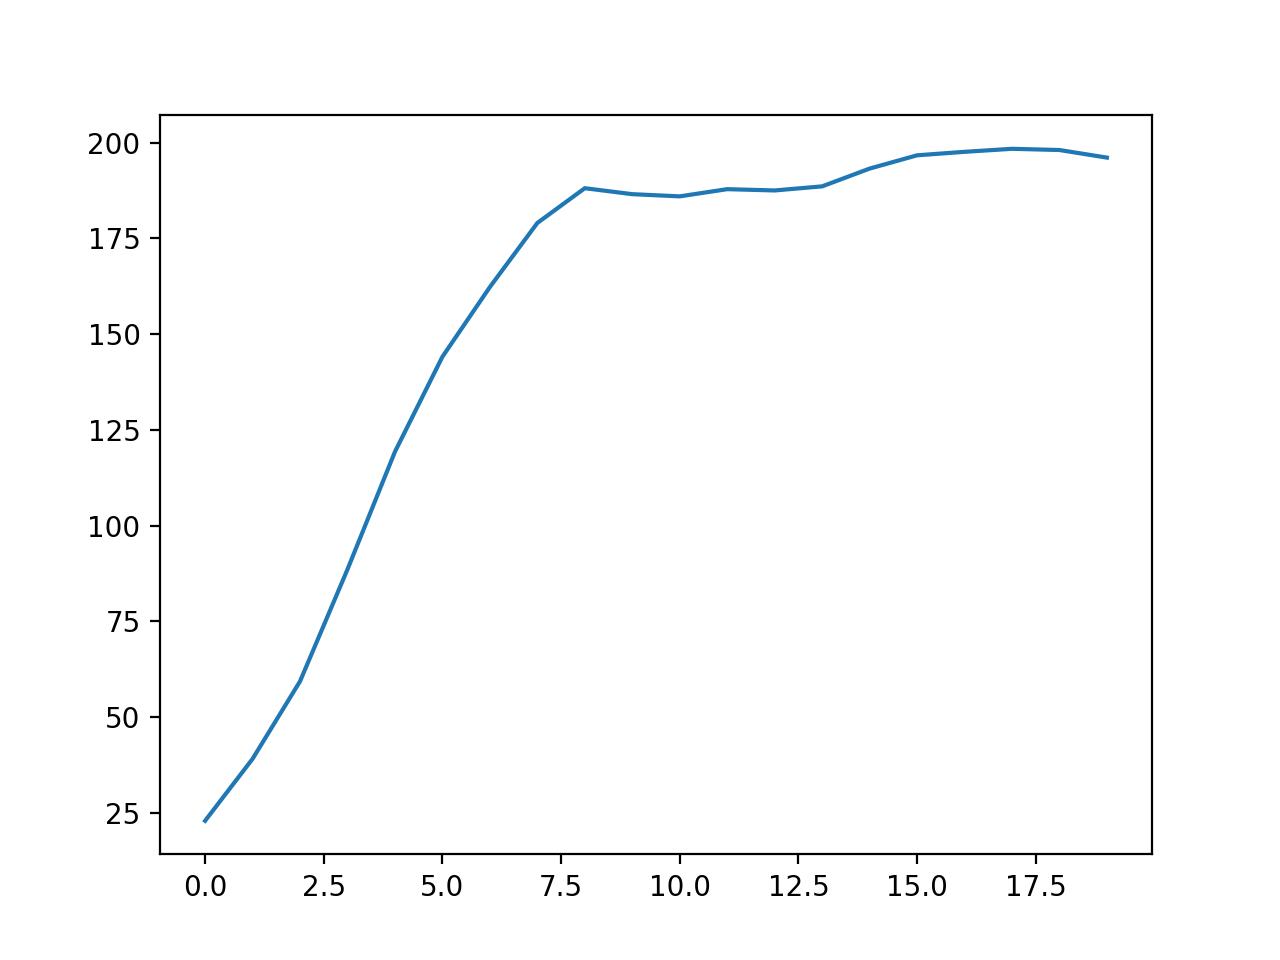

In [44]:
df_trials['episode_reward_mean'].plot()

### Exercise:
Look at same with tensorboard. In a console, start tensorboard with: `tensorboard --logdir=~/ray_results`

In [45]:
! pip install tensorboard

In [46]:
! tensorboard --logdir=~/ray_results # Kernel -> interupt to stop

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.1.0 at http://localhost:6007/ (Press CTRL+C to quit)
^C


### More details on tune
* https://github.com/ray-project/ray/tree/master/rllib/tuned_examples list essentially yaml that can be used with the command line interface for tune
* we will use tune to run of the a3c examples (this is a cpu only regression test)

In [47]:
! pip install pyyaml # install package to read yamls, import with yaml

In [48]:
import yaml
import urllib

In [49]:
# grab an a3c example from github
link = "https://raw.githubusercontent.com/ray-project/ray/master/rllib/tuned_examples/pong-a3c.yaml"
f = urllib.request.urlopen(link)
yaml_example = f.read()
print(yaml_example)

b'# This gets to ~19-20 reward in ~30 minutes / 4m steps on a m4.10xl instance\n# TODO(rliaw): this has regressed in performance\npong-a3c:\n    env: PongDeterministic-v4\n    run: A3C\n    config:\n        num_workers: 16\n        sample_batch_size: 20\n        use_pytorch: false\n        vf_loss_coeff: 0.5\n        entropy_coeff: 0.01\n        gamma: 0.99\n        grad_clip: 40.0\n        lambda: 1.0\n        lr: 0.0001\n        observation_filter: NoFilter\n        preprocessor_pref: rllib\n        model:\n            use_lstm: true\n            conv_activation: elu\n            dim: 42\n            grayscale: true\n            zero_mean: false\n            # Reduced channel depth and kernel size from default\n            conv_filters: [\n                [32, [3, 3], 2],\n                [32, [3, 3], 2],\n                [32, [3, 3], 2],\n                [32, [3, 3], 2],\n            ]\n'


In [50]:
tune_config_example = yaml.safe_load(yaml_example)
print(tune_config_example)

{'pong-a3c': {'env': 'PongDeterministic-v4', 'run': 'A3C', 'config': {'num_workers': 16, 'sample_batch_size': 20, 'use_pytorch': False, 'vf_loss_coeff': 0.5, 'entropy_coeff': 0.01, 'gamma': 0.99, 'grad_clip': 40.0, 'lambda': 1.0, 'lr': 0.0001, 'observation_filter': 'NoFilter', 'preprocessor_pref': 'rllib', 'model': {'use_lstm': True, 'conv_activation': 'elu', 'dim': 42, 'grayscale': True, 'zero_mean': False, 'conv_filters': [[32, [3, 3], 2], [32, [3, 3], 2], [32, [3, 3], 2], [32, [3, 3], 2]]}}}}


In [51]:
tune_config_example["pong-a3c"]["config"]["num_workers"]=2
tune_config_example["pong-a3c"]["stop"] = {"training_iteration": 10}
print(tune_config_example)

{'pong-a3c': {'env': 'PongDeterministic-v4', 'run': 'A3C', 'config': {'num_workers': 2, 'sample_batch_size': 20, 'use_pytorch': False, 'vf_loss_coeff': 0.5, 'entropy_coeff': 0.01, 'gamma': 0.99, 'grad_clip': 40.0, 'lambda': 1.0, 'lr': 0.0001, 'observation_filter': 'NoFilter', 'preprocessor_pref': 'rllib', 'model': {'use_lstm': True, 'conv_activation': 'elu', 'dim': 42, 'grayscale': True, 'zero_mean': False, 'conv_filters': [[32, [3, 3], 2], [32, [3, 3], 2], [32, [3, 3], 2], [32, [3, 3], 2]]}}, 'stop': {'training_iteration': 10}}}


In [103]:
ray.tune.run_experiments(tune_config_example)

Trial name,status,loc
A3C_PongDeterministic-v4_4a3c1462,RUNNING,


2020-02-19 07:35:22,952	WARNING worker.py:1063 -- WARNING: 10 PYTHON workers have been started. This could be a result of using a large number of actors, or it could be a consequence of using nested tasks (see https://github.com/ray-project/ray/issues/3644) for some a discussion of workarounds.
2020-02-19 07:35:22,953	WARNING worker.py:1063 -- WARNING: 11 PYTHON workers have been started. This could be a result of using a large number of actors, or it could be a consequence of using nested tasks (see https://github.com/ray-project/ray/issues/3644) for some a discussion of workarounds.


Result for A3C_PongDeterministic-v4_4a3c1462:
  custom_metrics: {}
  date: 2020-02-19_07-35-30
  done: false
  episode_len_mean: 933.0
  episode_reward_max: -19.0
  episode_reward_mean: -19.0
  episode_reward_min: -19.0
  episodes_this_iter: 1
  episodes_total: 1
  experiment_id: fb04f05f108d4f35b1b0e443d0014176
  experiment_tag: '0'
  hostname: GDA-Oryx-Pro
  info:
    apply_time_ms: 1.999
    dispatch_time_ms: 6.055
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 6.20143985748291
      model: {}
      policy_entropy: 35.828086853027344
      policy_loss: 4.84628963470459
      var_gnorm: 25.89760398864746
      vf_explained_var: -0.14878058433532715
      vf_loss: 0.20017409324645996
    num_steps_sampled: 2000
    num_steps_trained: 2000
    wait_time_ms: 28.359
  iterations_since_restore: 1
  node_ip: 192.168.1.170
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 42.48333333333333
    ram_util_percent: 72.73333333333333
  pid: 224

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_PongDeterministic-v4_4a3c1462,RUNNING,192.168.1.170:22426,1,7.68848,2000,-19


Result for A3C_PongDeterministic-v4_4a3c1462:
  custom_metrics: {}
  date: 2020-02-19_07-35-38
  done: false
  episode_len_mean: 923.8
  episode_reward_max: -18.0
  episode_reward_mean: -20.0
  episode_reward_min: -21.0
  episodes_this_iter: 4
  episodes_total: 5
  experiment_id: fb04f05f108d4f35b1b0e443d0014176
  experiment_tag: '0'
  hostname: GDA-Oryx-Pro
  info:
    apply_time_ms: 1.702
    dispatch_time_ms: 6.428
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 8.23530101776123
      model: {}
      policy_entropy: 35.81895446777344
      policy_loss: -7.796582221984863
      var_gnorm: 25.91107177734375
      vf_explained_var: -0.03810453414916992
      vf_loss: 2.049349546432495
    num_steps_sampled: 6000
    num_steps_trained: 6000
    wait_time_ms: 29.956
  iterations_since_restore: 2
  node_ip: 192.168.1.170
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 61.36363636363635
    ram_util_percent: 77.70000000000002
  pid: 2242

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_PongDeterministic-v4_4a3c1462,RUNNING,192.168.1.170:22426,2,15.3946,6000,-20


Result for A3C_PongDeterministic-v4_4a3c1462:
  custom_metrics: {}
  date: 2020-02-19_07-35-46
  done: false
  episode_len_mean: 961.3
  episode_reward_max: -18.0
  episode_reward_mean: -20.3
  episode_reward_min: -21.0
  episodes_this_iter: 5
  episodes_total: 10
  experiment_id: fb04f05f108d4f35b1b0e443d0014176
  experiment_tag: '0'
  hostname: GDA-Oryx-Pro
  info:
    apply_time_ms: 1.92
    dispatch_time_ms: 5.979
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 25.66436004638672
      model: {}
      policy_entropy: 35.73349380493164
      policy_loss: -15.589995384216309
      var_gnorm: 25.9265079498291
      vf_explained_var: 0.009191632270812988
      vf_loss: 3.177231788635254
    num_steps_sampled: 10000
    num_steps_trained: 10000
    wait_time_ms: 29.865
  iterations_since_restore: 3
  node_ip: 192.168.1.170
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 61.17272727272728
    ram_util_percent: 81.27272727272727
  pid: 2

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_PongDeterministic-v4_4a3c1462,RUNNING,192.168.1.170:22426,3,22.9931,10000,-20.3


Result for A3C_PongDeterministic-v4_4a3c1462:
  custom_metrics: {}
  date: 2020-02-19_07-35-53
  done: false
  episode_len_mean: 925.1428571428571
  episode_reward_max: -18.0
  episode_reward_mean: -20.428571428571427
  episode_reward_min: -21.0
  episodes_this_iter: 4
  episodes_total: 14
  experiment_id: fb04f05f108d4f35b1b0e443d0014176
  experiment_tag: '0'
  hostname: GDA-Oryx-Pro
  info:
    apply_time_ms: 1.613
    dispatch_time_ms: 6.634
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 10.969645500183105
      model: {}
      policy_entropy: 35.18730163574219
      policy_loss: -5.459041118621826
      var_gnorm: 25.94123077392578
      vf_explained_var: -0.00879526138305664
      vf_loss: 1.4715474843978882
    num_steps_sampled: 14000
    num_steps_trained: 14000
    wait_time_ms: 27.919
  iterations_since_restore: 4
  node_ip: 192.168.1.170
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 60.02
    ram_util_percent: 84.48
  p

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_PongDeterministic-v4_4a3c1462,RUNNING,192.168.1.170:22426,4,30.5197,14000,-20.4286


Result for A3C_PongDeterministic-v4_4a3c1462:
  custom_metrics: {}
  date: 2020-02-19_07-36-01
  done: false
  episode_len_mean: 879.6
  episode_reward_max: -18.0
  episode_reward_mean: -20.6
  episode_reward_min: -21.0
  episodes_this_iter: 6
  episodes_total: 20
  experiment_id: fb04f05f108d4f35b1b0e443d0014176
  experiment_tag: '0'
  hostname: GDA-Oryx-Pro
  info:
    apply_time_ms: 1.874
    dispatch_time_ms: 5.737
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 6.833588123321533
      model: {}
      policy_entropy: 35.36431121826172
      policy_loss: -1.3010973930358887
      var_gnorm: 25.95338249206543
      vf_explained_var: 0.010339975357055664
      vf_loss: 1.2181718349456787
    num_steps_sampled: 18000
    num_steps_trained: 18000
    wait_time_ms: 28.391
  iterations_since_restore: 5
  node_ip: 192.168.1.170
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 58.93636363636363
    ram_util_percent: 87.5909090909091
  pid:

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_PongDeterministic-v4_4a3c1462,RUNNING,192.168.1.170:22426,5,37.9132,18000,-20.6


Result for A3C_PongDeterministic-v4_4a3c1462:
  custom_metrics: {}
  date: 2020-02-19_07-36-08
  done: false
  episode_len_mean: 866.5
  episode_reward_max: -18.0
  episode_reward_mean: -20.666666666666668
  episode_reward_min: -21.0
  episodes_this_iter: 4
  episodes_total: 24
  experiment_id: fb04f05f108d4f35b1b0e443d0014176
  experiment_tag: '0'
  hostname: GDA-Oryx-Pro
  info:
    apply_time_ms: 1.551
    dispatch_time_ms: 5.731
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 27.192237854003906
      model: {}
      policy_entropy: 34.851470947265625
      policy_loss: -17.285873413085938
      var_gnorm: 25.980113983154297
      vf_explained_var: 0.0008727908134460449
      vf_loss: 3.459970474243164
    num_steps_sampled: 22000
    num_steps_trained: 22000
    wait_time_ms: 29.62
  iterations_since_restore: 6
  node_ip: 192.168.1.170
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 58.48181818181818
    ram_util_percent: 90.7454

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_PongDeterministic-v4_4a3c1462,RUNNING,192.168.1.170:22426,6,45.3685,22000,-20.6667


Result for A3C_PongDeterministic-v4_4a3c1462:
  custom_metrics: {}
  date: 2020-02-19_07-36-15
  done: false
  episode_len_mean: 852.6666666666666
  episode_reward_max: -18.0
  episode_reward_mean: -20.733333333333334
  episode_reward_min: -21.0
  episodes_this_iter: 6
  episodes_total: 30
  experiment_id: fb04f05f108d4f35b1b0e443d0014176
  experiment_tag: '0'
  hostname: GDA-Oryx-Pro
  info:
    apply_time_ms: 2.217
    dispatch_time_ms: 5.555
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 34.026512145996094
      model: {}
      policy_entropy: 35.20148849487305
      policy_loss: -24.611927032470703
      var_gnorm: 26.00190544128418
      vf_explained_var: -0.06230795383453369
      vf_loss: 5.48494291305542
    num_steps_sampled: 26000
    num_steps_trained: 26000
    wait_time_ms: 29.047
  iterations_since_restore: 7
  node_ip: 192.168.1.170
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 57.980000000000004
    ram_util_percen

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_PongDeterministic-v4_4a3c1462,RUNNING,192.168.1.170:22426,7,52.7484,26000,-20.7333


Result for A3C_PongDeterministic-v4_4a3c1462:
  custom_metrics: {}
  date: 2020-02-19_07-36-23
  done: false
  episode_len_mean: 865.1176470588235
  episode_reward_max: -18.0
  episode_reward_mean: -20.705882352941178
  episode_reward_min: -21.0
  episodes_this_iter: 4
  episodes_total: 34
  experiment_id: fb04f05f108d4f35b1b0e443d0014176
  experiment_tag: '0'
  hostname: GDA-Oryx-Pro
  info:
    apply_time_ms: 1.56
    dispatch_time_ms: 5.832
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 3.5779833793640137
      model: {}
      policy_entropy: 35.12071228027344
      policy_loss: -0.23137566447257996
      var_gnorm: 26.018766403198242
      vf_explained_var: -0.0048400163650512695
      vf_loss: 1.1878029108047485
    num_steps_sampled: 30000
    num_steps_trained: 30000
    wait_time_ms: 29.938
  iterations_since_restore: 8
  node_ip: 192.168.1.170
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 57.27272727272726
    ram_util_pe

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_PongDeterministic-v4_4a3c1462,RUNNING,192.168.1.170:22426,8,60.0754,30000,-20.7059


Result for A3C_PongDeterministic-v4_4a3c1462:
  custom_metrics: {}
  date: 2020-02-19_07-36-30
  done: false
  episode_len_mean: 879.2894736842105
  episode_reward_max: -18.0
  episode_reward_mean: -20.657894736842106
  episode_reward_min: -21.0
  episodes_this_iter: 4
  episodes_total: 38
  experiment_id: fb04f05f108d4f35b1b0e443d0014176
  experiment_tag: '0'
  hostname: GDA-Oryx-Pro
  info:
    apply_time_ms: 1.737
    dispatch_time_ms: 5.849
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 33.95669174194336
      model: {}
      policy_entropy: 35.040000915527344
      policy_loss: -25.83295440673828
      var_gnorm: 26.031211853027344
      vf_explained_var: 0.0006200671195983887
      vf_loss: 5.436253547668457
    num_steps_sampled: 34000
    num_steps_trained: 34000
    wait_time_ms: 31.685
  iterations_since_restore: 9
  node_ip: 192.168.1.170
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 57.730000000000004
    ram_util_perc

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_PongDeterministic-v4_4a3c1462,RUNNING,192.168.1.170:22426,9,67.4694,34000,-20.6579


Result for A3C_PongDeterministic-v4_4a3c1462:
  custom_metrics: {}
  date: 2020-02-19_07-36-38
  done: true
  episode_len_mean: 880.047619047619
  episode_reward_max: -18.0
  episode_reward_mean: -20.69047619047619
  episode_reward_min: -21.0
  episodes_this_iter: 4
  episodes_total: 42
  experiment_id: fb04f05f108d4f35b1b0e443d0014176
  experiment_tag: '0'
  hostname: GDA-Oryx-Pro
  info:
    apply_time_ms: 1.75
    dispatch_time_ms: 6.067
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 11.634791374206543
      model: {}
      policy_entropy: 34.87805938720703
      policy_loss: 7.163380146026611
      var_gnorm: 26.045175552368164
      vf_explained_var: -0.0026030540466308594
      vf_loss: 0.5883638858795166
    num_steps_sampled: 38000
    num_steps_trained: 38000
    wait_time_ms: 28.973
  iterations_since_restore: 10
  node_ip: 192.168.1.170
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 58.0090909090909
    ram_util_percent:

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_PongDeterministic-v4_4a3c1462,TERMINATED,,10,74.8096,38000,-20.6905


Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_PongDeterministic-v4_4a3c1462,TERMINATED,,10,74.8096,38000,-20.6905


[A3C_PongDeterministic-v4_4a3c1462]

# Getting status and stopping ray
* https://ray.readthedocs.io/en/latest/package-ref.html#ray-package-reference
* https://ray.readthedocs.io/en/latest/package-ref.html#ray.init

In [52]:
ray.is_initialized()

True

In [53]:
ray.nodes()

[{'NodeID': '41c26152d8eecc51f1a4fec2eec4a79eb681081f',
  'Alive': True,
  'NodeManagerAddress': '10.236.176.76',
  'NodeManagerHostname': 'qian-XPS-8920',
  'NodeManagerPort': 54719,
  'ObjectManagerPort': 46637,
  'ObjectStoreSocketName': '/tmp/ray/session_2020-02-23_17-44-43_860531_30552/sockets/plasma_store',
  'RayletSocketName': '/tmp/ray/session_2020-02-23_17-44-43_860531_30552/sockets/raylet',
  'Resources': {'node:10.236.176.76': 1.0,
   'object_store_memory': 25.0,
   'CPU': 8.0,
   'memory': 74.0,
   'GPU': 1.0},
  'alive': True}]

In [54]:
ray.cluster_resources()

{'node:10.236.176.76': 1.0,
 'object_store_memory': 25.0,
 'CPU': 8.0,
 'memory': 74.0,
 'GPU': 1.0}

In [55]:
ray.shutdown()

In [56]:
ray.is_initialized()

False